In [1]:
import os
import sys
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

sys.path.append('../')

from mpl_settings_v3 import *

%matplotlib inline

draft_figs_dir = '../../../drafts/results_summary/figs'
figs_dir = '../../../figs/clustering'

In [2]:
def protocolName(mode, init_mu, step, samples, transit, decorr, rampe):
    
    protocol = '{}_{}_muInit{:.6f}_step{:.6f}_samples{:06}_transit{:06d}_decorr{:06d}'.format(mode, rampe, init_mu, step, samples, transit, decorr)
    
    return protocol

get_mu = lambda name: float(name.split('mu')[1].split('_')[0])
get_sample = lambda name: int(name.split('sample')[1].split('.')[0])

In [54]:
net_dir = '../../../networks/real'

mode = 'maxC'
min_mu = 0
max_mu = 10
step = 0.1
samples = 100
decorr = 10
transit = 100
seed = 0

rampes = ['annealing', 'cooling']
seed_dir = 'seed{:05}'.format(seed)
columns = ['mu', 'sample', 'C', 'Cws']


networks = ['ca-netscience', 
            'ca-GrQc',
            'bio-yeast',
            'bio-diseasome',
            'bio-celegans',
            'powergrid',
            'euroroad_simple_gcc',
            'CElegansNeural',
            #'polblogs_simple_gcc',
            #'EColiPIN_simple_gcc',
            #'US-airports-500'
            ]

sizes = []
for network in networks:
    full_input_file = os.path.join(net_dir, network, network + '.txt')
    try:
        g = ig.Graph().Read_Edgelist(full_input_file, directed=False)
    except:
        print('ERROR: Could not read file', network)
        continue
    N = g.vcount()
    M = g.ecount()
    sizes.append([network, N, M])
    
networks = list(zip(*sorted(sizes, key=lambda x: x[2])))[0]

dfs = {}
for network in networks:
    print(network)
    dfs[network] = {}
    for rampe in rampes:

        if rampe == 'annealing':
            init_mu = min_mu
        else:
            init_mu = max_mu
        protocol = protocolName(mode, init_mu, step, samples, transit, decorr, rampe)
        input_dir = os.path.join(net_dir, network, protocol, seed_dir)
        if not os.path.isdir(input_dir):
            print(input_dir)

        csv_file = os.path.join(input_dir, rampe + '.csv')   
        if os.path.isfile(csv_file):
            df = pd.read_csv(csv_file)
        else:
            files = sorted(os.listdir(input_dir))  
            data = []
            for f in files:
                mu = get_mu(f)
                sample = get_sample(f)
                full_path = os.path.join(input_dir, f)
                g = ig.Graph().Read_Edgelist(full_path, directed=False)
                C = g.transitivity_undirected(mode='zero')
                Cws = g.transitivity_avglocal_undirected(mode='zero')
                data.append([mu, sample, C, Cws])

            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file)
        dfs[network][rampe] = df

ca-netscience
bio-diseasome
euroroad_simple_gcc
bio-yeast
bio-celegans
CElegansNeural
powergrid
ca-GrQc


ca-netscience
bio-diseasome
euroroad
bio-yeast
bio-celegans
CElegansNeural
powergrid
ca-GrQc


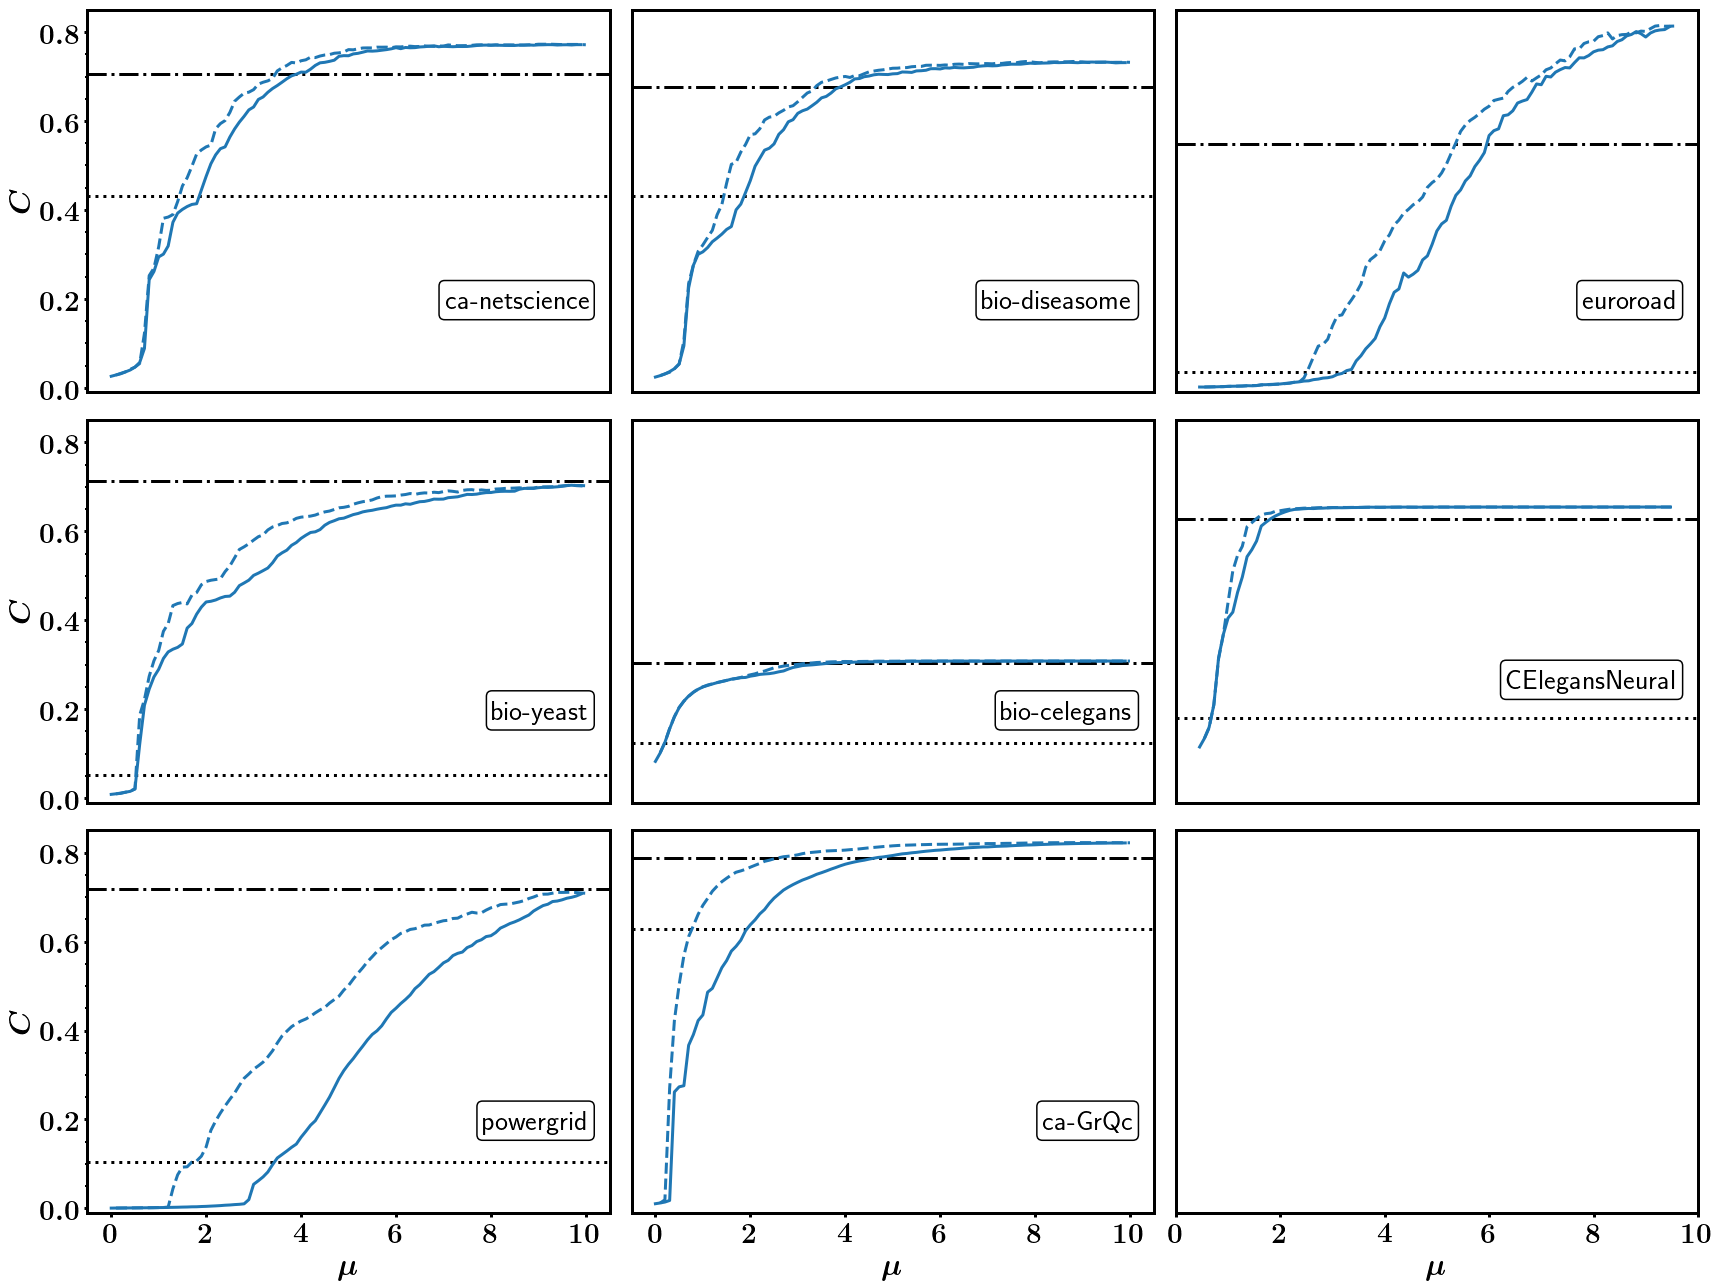

In [45]:
input_dir = '../../../data/clustering'
full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
with open(full_file_path, 'rb') as f:
    data = pickle.load(f)
    
linestyles = ['-', '--']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

text_x = 0.96
text_dict = {'CElegansNeural': (text_x, 0.3)}

ncols, nrows = 3, 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)


for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes[:,0]:
    ax.set_ylabel(r'$C$')
    ax.set_yticks(np.arange(0, 1.2, 0.2))
for ax in axes[-1,:]:
    ax.set_xlabel(r'$\mu$')
    ax.set_xticks(np.arange(0, 11, 2))
    

    
for ax, network in zip(axes.flatten(), networks):

    C = data[network]['C'][0]
    maxC = data[network]['C'][2]
    ax.axhline(C, linestyle=':', color='k')
    ax.axhline(maxC, linestyle='-.', color='k')
    #maxCws = data[network]['Cws'][2]
    #ax.axhline(maxCws, linestyle='-.', color=colors[1])
    
    for i, rampe in enumerate(rampes):
        df = dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index
        C_values = mean_df.C
        Cws_values = mean_df.Cws

        if rampe == 'annealing':
            ax.plot(mu_values, C_values, color=colors[0], linestyle=linestyles[i], label='')
            #ax.plot(mu_values, Cws_values, color=colors[1], linestyle=linestyles[i], label=r'$\bar{c}$')
        else:
            ax.plot(mu_values, C_values, color=colors[0], linestyle=linestyles[i], label='')
            #ax.plot(mu_values, Cws_values, color=colors[1], linestyle=linestyles[i], label='')
    
    
    if '_simple_gcc' in network:
        title = network.split('_')[0]
    else:
        title = network
    print(title)
    ax.set_ylim(-0.01, 0.85)
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    
    if network in text_dict:
        ax.text(*text_dict[network], title, bbox=bbox, transform=ax.transAxes, fontsize=28, 
                horizontalalignment='right')
    else:
        ax.text(text_x, 0.22, title, bbox=bbox, transform=ax.transAxes, fontsize=28, 
                horizontalalignment='right')
    #ax.legend(loc='best')
    
plt.tight_layout()
plt.savefig(os.path.join(draft_figs_dir, 'Cmax_MC_and_greedy.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cmax_MC_and_greedy.png'))
plt.show()

ca-netscience
bio-diseasome
euroroad
bio-yeast
bio-celegans
CElegansNeural
powergrid
ca-GrQc


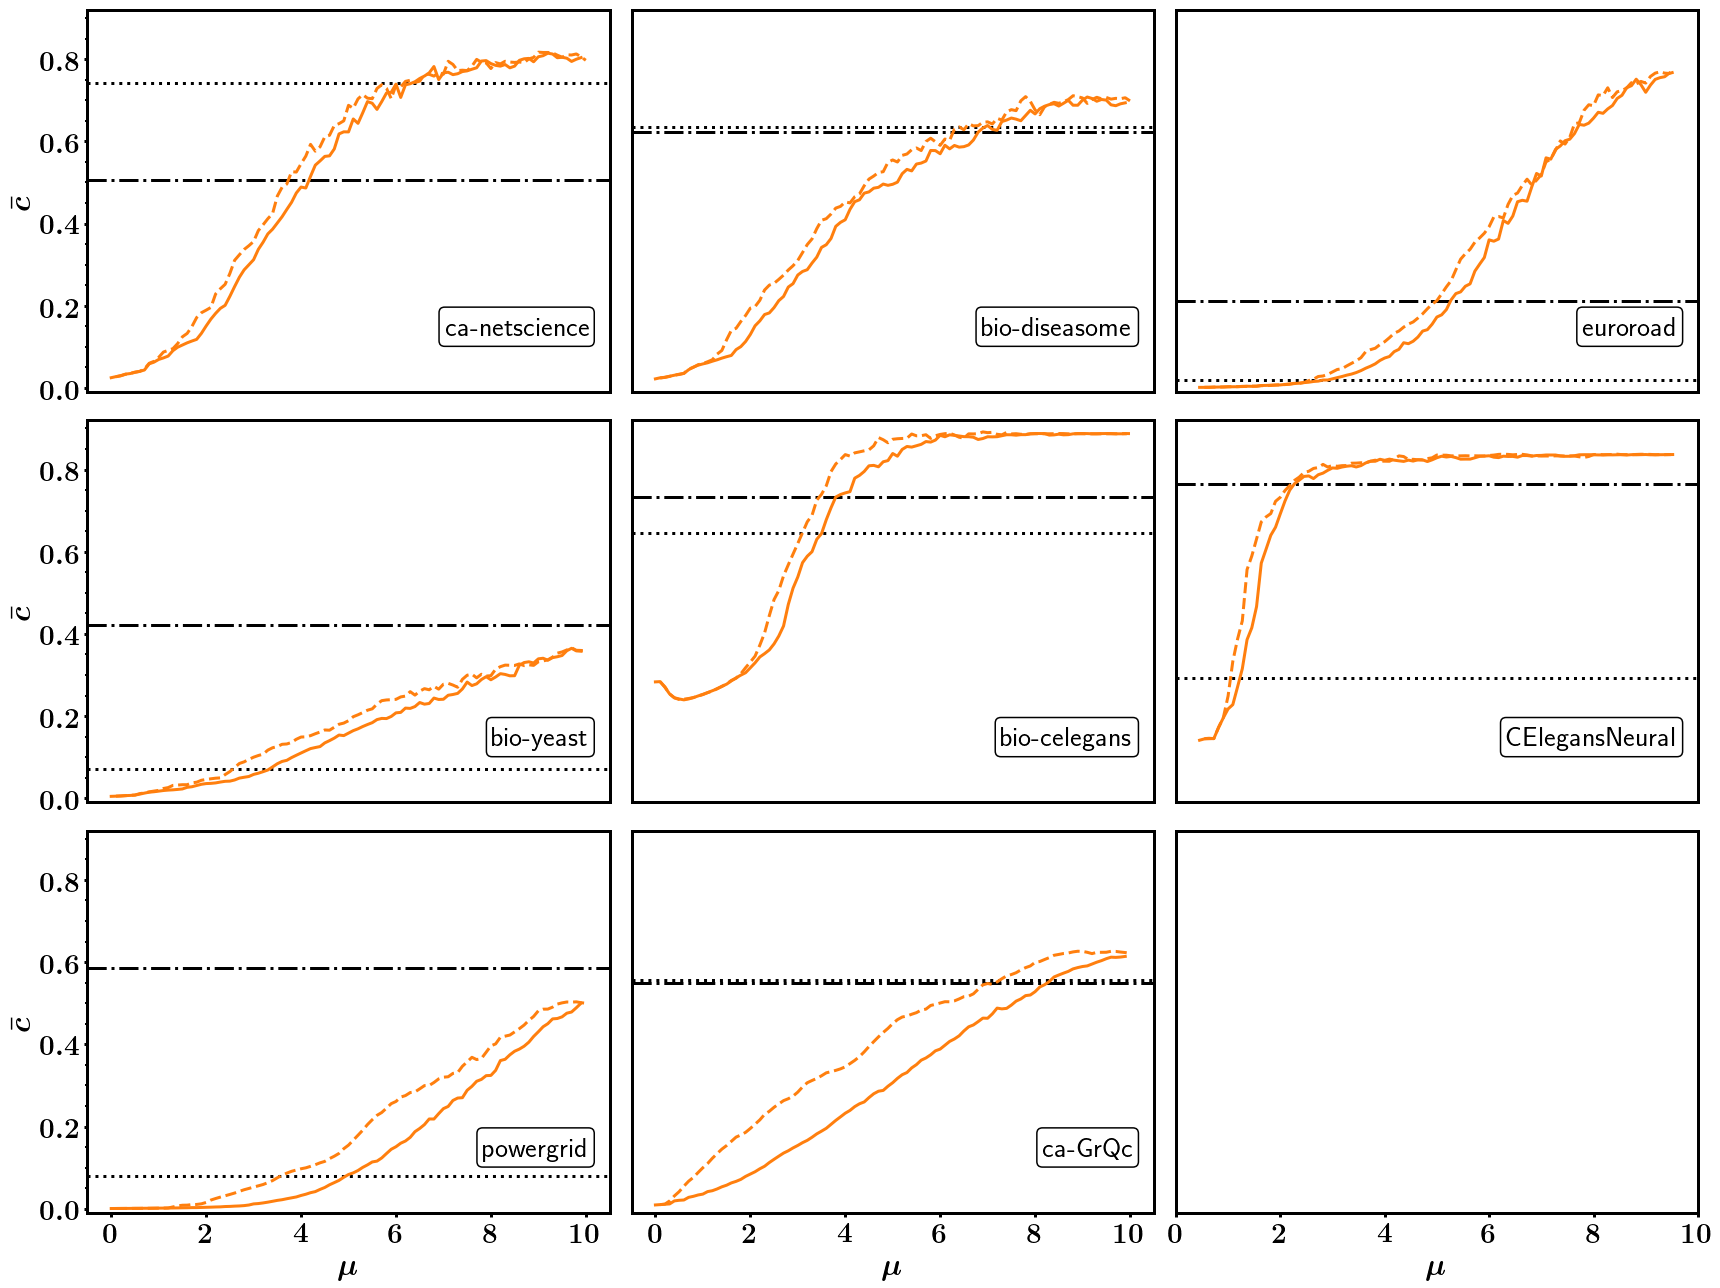

In [55]:
input_dir = '../../../data/clustering'
full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
with open(full_file_path, 'rb') as f:
    data = pickle.load(f)
    
linestyles = ['-', '--']

ncols, nrows = 3, 3
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes[:,0]:
    ax.set_ylabel(r'$\bar{c}$')
    ax.set_yticks(np.arange(0, 1.2, 0.2))
for ax in axes[-1,:]:
    ax.set_xlabel(r'$\mu$')
    ax.set_xticks(np.arange(0, 11, 2))

for ax, network in zip(axes.flatten(), networks):

    Cws = data[network]['Cws'][0]
    maxCws = data[network]['Cws'][2]
    ax.axhline(Cws, linestyle=':', color='k')
    ax.axhline(maxCws, linestyle='-.', color='k')

    for i, rampe in enumerate(rampes):
        df = dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index

        Cws_values = mean_df.Cws
        ax.plot(mu_values, Cws_values, color=colors[1], linestyle=linestyles[i], label=r'')

    if '_simple_gcc' in network:
        title = network.split('_')[0]
    else:
        title = network
    print(title)
    ax.set_ylim(-0.01, 0.92)
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    ax.text(0.96, 0.15, title, bbox=bbox, transform=ax.transAxes, fontsize=28, 
            horizontalalignment='right')
    
plt.tight_layout()
plt.savefig(os.path.join(draft_figs_dir, 'Cwsmax_MC_and_greedy.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cwsmax_MC_and_greedy.png'))
plt.show()

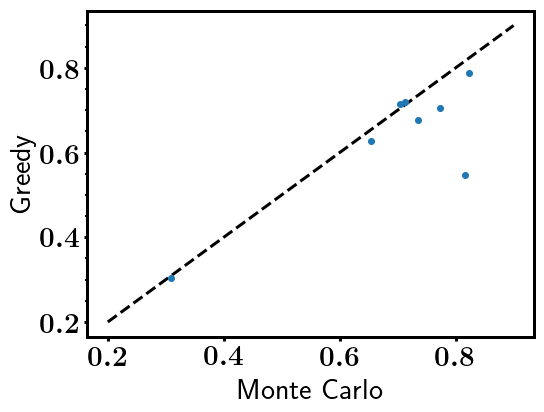

In [60]:
maxC_greedy_values = []
maxC_MC_values = []

for network in networks:
    maxC_greedy = data[network]['C'][2]
    maxC_MC = np.max([dfs[network]['annealing'].C.max(), dfs[network]['cooling'].C.max()])
    
    maxC_greedy_values.append(maxC_greedy)
    maxC_MC_values.append(maxC_MC)
    
fig, ax = plt.subplots(figsize=(8, 6))

X = np.linspace(0.2, 0.9, 100)
ax.plot(X, X, '--', color='k')

X, Y = zip(*sorted(zip(maxC_MC_values, maxC_greedy_values), key=lambda x: x[0]))
ax.plot(X, Y, 'o', label=r'$C_{\mathrm{max}}$')
ax.set_xlabel(r'Monte Carlo')
ax.set_ylabel(r'Greedy')

plt.savefig(os.path.join(draft_figs_dir, 'Cmax_MC_vs_greedy.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cmax_MC_vs_greedy.png'))
plt.show()

In [46]:
def build_df(net_dir, network, n_seeds, rand_mcs, samples):
    seeds = range(1, n_seeds+1)
    
    data = []
    for seed in seeds:

        seed_dir = 'seed{:05}'.format(seed)
        protocol = 'relaxation_randMCS{}_samples{}'.format(rand_mcs, samples)
        input_dir = os.path.join(net_dir, network, protocol, seed_dir)
        if not os.path.isdir(input_dir):
            print(input_dir)
        files = sorted(os.listdir(input_dir))  

        for f in files:
            swap = float(f[1:-4])
            full_path = os.path.join(input_dir, f)
            g = ig.Graph().Read_Edgelist(full_path, directed=False)
            C = g.transitivity_undirected(mode='zero')
            Cws = g.transitivity_avglocal_undirected(mode='zero')
            data.append([seed, swap, C, Cws])
    data = sorted(data, key=lambda x: x[0])    
    arr_data = np.array(data)

    columns = ['seed', 'swap', 'C', 'Cws']
    df = pd.DataFrame(data, columns=columns)
    return df

In [47]:
relax_dfs = {}
relax_mean_dfs = {}
relax_std_dfs = {}

In [49]:
net_dir = '../../../networks/real'
n_seeds = 10
rand_mcs = 100
samples = 100

networks = ['ca-netscience', 
            'ca-GrQc',
            'bio-yeast',
            'bio-diseasome',
            'bio-celegans',
            'powergrid',
            'euroroad_simple_gcc',
            'CElegansNeural',
            'polblogs_simple_gcc',
            'EColiPIN_simple_gcc',
            #'US-airports-500'
            'CElegansPIN_simple_gcc'
            ]

for network in networks:
    print(network)
    if network in relax_dfs:
        continue
        
    df = build_df(net_dir, network, n_seeds, rand_mcs, samples)
    
    mean_df = df.groupby(by='swap').mean()
    del mean_df['seed']
    std_df = df.groupby(by='swap').std()
    del std_df['seed']

    relax_dfs[network] = df
    relax_mean_dfs[network] = mean_df
    relax_std_dfs[network] = std_df

ca-netscience
ca-GrQc
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad_simple_gcc
CElegansNeural
polblogs_simple_gcc
EColiPIN_simple_gcc
CElegansPIN_simple_gcc


ca-netscience
ca-GrQc
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad
CElegansNeural
polblogs
EColiPIN
CElegansPIN


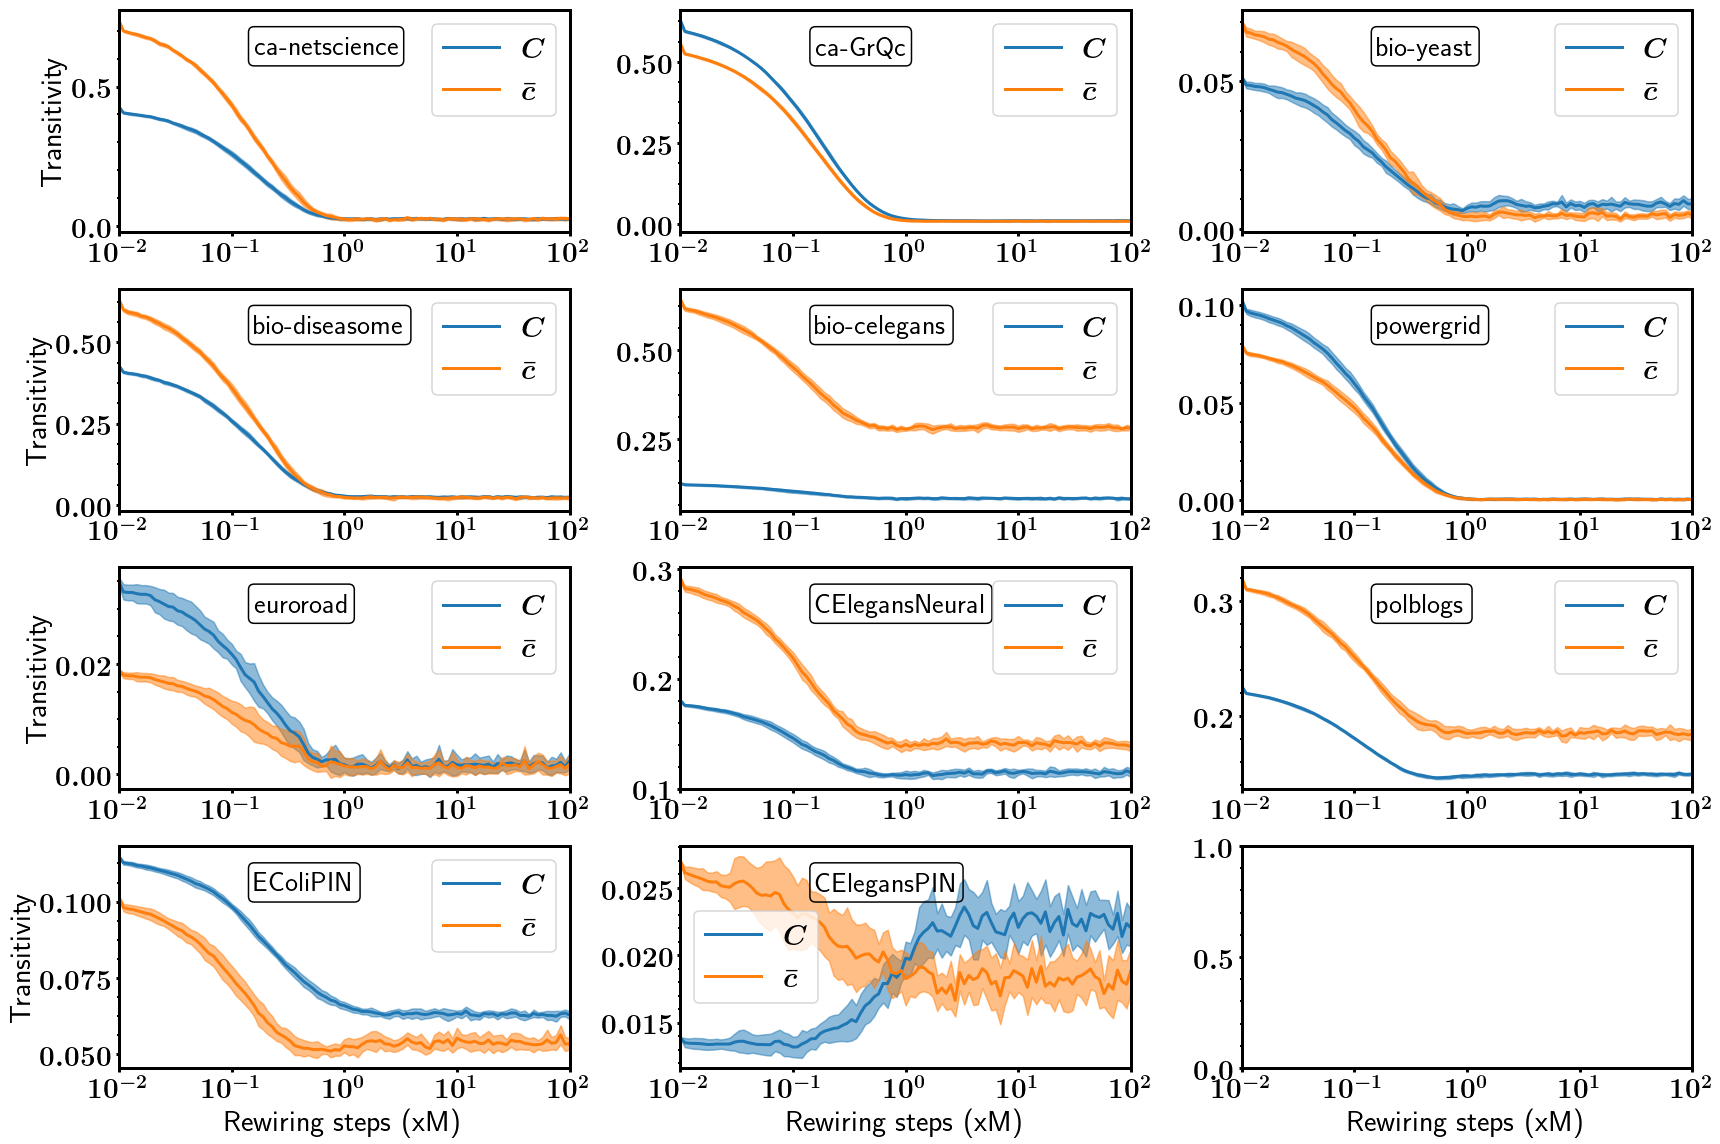

In [51]:
ncols, nrows = 3, 4
fig, axes = plt.subplots(figsize=(8*ncols, 4*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(0.01, 100)
    
for ax in axes[:,0]:
    ax.set_ylabel('Transitivity')
for ax in axes[-1,:]:
    ax.set_xlabel('Rewiring steps (xM)')
    
for ax, network in zip(axes.flatten(), networks):
    df = relax_dfs[network]
    mean_df = relax_mean_dfs[network]
    std_df = relax_std_dfs[network]
    
    swap_values = mean_df.index
    C_values = mean_df.C
    Cws_values = mean_df.Cws
    ax.plot(swap_values, C_values, color=colors[0], label=r'$C$')
    ax.fill_between(swap_values, C_values-std_df.C, C_values+std_df.C, 
                    alpha=0.5, color=colors[0])
    ax.plot(swap_values, Cws_values, color=colors[1], label=r'$\bar{c}$')
    ax.fill_between(swap_values, Cws_values-std_df.Cws, Cws_values+std_df.Cws, 
                    alpha=0.5, color=colors[1])

    if '_simple_gcc' in network:
        title = network.split('_')[0]
    else:
        title = network
    print(title)
    bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.2')
    ax.text(0.3, 0.8, title, transform=ax.transAxes, bbox=bbox, fontsize=28)
    ax.legend(loc='best', fontsize=28)

plt.tight_layout()
plt.savefig(os.path.join(draft_figs_dir, 'relaxation.pdf'))
plt.savefig(os.path.join(figs_dir, 'relaxation.png'))
plt.show()

In [10]:
from clustering_methods import get_C_rand_CM

C_rand_CM_values = {}
C_rand_rewire_values = {}
Cws_rand_CM_values = {}
Cws_rand_rewire_values = {}
for network in networks:
    print(network)
    full_path = os.path.join(net_dir, network, network + '.txt')
    g = ig.Graph().Read_Edgelist(full_path, directed=False)
    degSeq = g.degree()
    C_rand_CM_values[network], Cws_rand_CM_values[network] = get_C_rand_CM(degSeq, samples=10, package='ig')
    df = dfs[network]
    C_rand_rewire_values[network] = df[df['seed']==1].C[-100:]
    Cws_rand_rewire_values[network] = df[df['seed']==1].Cws[-100:]

ca-netscience
bio-yeast
bio-diseasome
bio-celegans
powergrid
euroroad_simple_gcc
polblogs_simple_gcc
EColiPIN_simple_gcc
US-airports-500


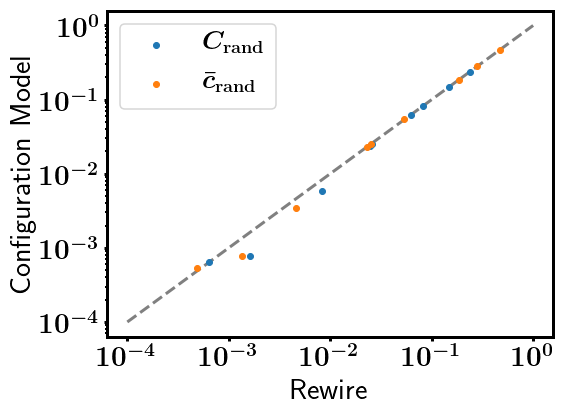

In [21]:
C_rewire_mean_values = []
Cws_rewire_mean_values = []
C_CM_mean_values = []
Cws_CM_mean_values = []
for network in networks:
    
    C_CM_mean = C_rand_CM_values[network].mean()
    C_CM_std = C_rand_CM_values[network].std()
    C_rewire_mean = C_rand_rewire_values[network].mean()
    C_rewire_std = C_rand_rewire_values[network].std()
    
    Cws_CM_mean = Cws_rand_CM_values[network].mean()
    Cws_CM_std = Cws_rand_CM_values[network].std()
    Cws_rewire_mean = Cws_rand_rewire_values[network].mean()
    Cws_rewire_std = Cws_rand_rewire_values[network].std()
    
    C_rewire_mean_values.append(C_rewire_mean)
    Cws_rewire_mean_values.append(Cws_rewire_mean)
    C_CM_mean_values.append(C_CM_mean)
    Cws_CM_mean_values.append(Cws_CM_mean)
    
ncols, nrows = 1, 1
fig, ax = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
ax.set_xscale('log')
ax.set_yscale('log')
X = np.linspace(0.0001, 1, 100)
ax.plot(X, X, linestyle='--', color='grey')
ax.plot(C_rewire_mean_values, C_CM_mean_values, 'o', 
               color=colors[0], label=r'$C_{\mathrm{rand}}$')
ax.plot(Cws_rewire_mean_values, Cws_CM_mean_values, 'o',  
               color=colors[1], label=r'$\bar{c}_{\mathrm{rand}}$')
ax.set_xlabel('Rewire')
ax.set_ylabel('Configuration Model')
ax.legend(loc='best')
plt.savefig(os.path.join(draft_figs_dir, 'CrandCM_vs_CrandRewire.pdf'))
plt.savefig(os.path.join(figs_dir, 'CrandCM_vs_CrandRewire.png'))
plt.show()

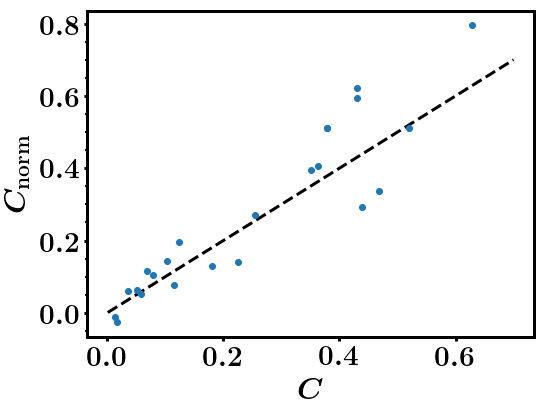

In [38]:
input_dir = '../../../data/clustering'
full_file_path = os.path.join(input_dir, 'Cnorm_data.pickle')
with open(full_file_path, 'rb') as f:
    data = pickle.load(f)
    
C_values = []
Cws_values = []
for network, values in data.items():
    C_values.append(values['C'])
    Cws_values.append(values['Cws'])
C_values = np.array(C_values)
Cws_values = np.array(Cws_values)

ncols, nrows = 1, 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = [axes]
X = np.linspace(0.001, 0.7, 100)

ax = axes[0]
ax.plot(X, X, linestyle='--', color='k')
ax.plot(C_values[:,0], C_values[:,3], 'o')
ax.set_xlabel(r'$C$')
ax.set_ylabel(r'$C_{\mathrm{norm}}$')

if False:
    ax = axes[1]
    ax.plot(X, X, linestyle='--', color='k')
    ax.plot(Cws_values[:,0], Cws_values[:,3], 'o')
    ax.set_xlabel(r'$\bar{c}$')
    ax.set_ylabel(r'$\bar{c}_{\mathrm{norm}}$')
    
plt.savefig(os.path.join(draft_figs_dir, 'Cnorm_vs_C.pdf'))
plt.savefig(os.path.join(figs_dir, 'Cnorm_vs_C.png'))
plt.show()

In [37]:
no_gcc = []
networks = os.listdir(net_dir)
for network in networks:
    if '_simple_gcc' in network:
        no_gcc.append(network[:-11])

for network in no_gcc:
    networks.remove(network)
    
networks.remove('dolphins')

sizes = []
for network in networks:
    full_input_file = os.path.join(net_dir, network, network + '.txt')
    try:
        g = ig.Graph().Read_Edgelist(full_input_file, directed=False)
    except:
        print('ERROR: Could not read file', network)
        continue
    N = g.vcount()
    M = g.ecount()
    sizes.append([network, N, M])
    
for network, N, M in sorted(sizes, key=lambda x: x[2]):
    print('{:25} {:5} {:5}'.format(network, N, M))

ca-netscience               379   914
bio-diseasome               516  1188
euroroad_simple_gcc        1039  1305
HPyloriPIN_simple_gcc       688  1356
MMusculusPIN_simple_gcc    1229  1612
bio-yeast                  1458  1948
bio-celegans                453  2025
CElegansNeural              297  2148
jazz_simple_gcc             198  2742
US-airports-500             500  2980
CElegansPIN_simple_gcc     2454  3924
school_day_2_duration       238  5539
school_day_1_duration       236  5899
powergrid                  4941  6594
HSapiensPIN_simple_gcc     4018  6754
EColiPIN_simple_gcc        2538 11515
ca-GrQc                    4158 13422
openflights_simple_gcc     2905 15645
polblogs_simple_gcc        1222 16714
SCerevisiaePIN_simple_gcc  5106 22593
PGP_simple_gcc            10680 24316


In [78]:
from triangleNet_methods import triangleGraph
import pathlib

net_dir = '../../../networks/real'
n_comp = 10
columns = ['mu', 'sample', 'N', 'M'] + ['N{:d}'.format(i) for i in range(1, n_comp+1)]
sizes = []
for network in networks:
    full_input_file = os.path.join(net_dir, network, network + '.txt')
    try:
        g = ig.Graph().Read_Edgelist(full_input_file, directed=False)
    except:
        print('ERROR: Could not read file', network)
        continue
    N = g.vcount()
    M = g.ecount()
    sizes.append([network, N, M])
networks = list(zip(*sorted(sizes, key=lambda x: x[2])))[0]

tr_dfs = {}
for network in networks[:1]:
    print(network)
    tr_dfs[network] = {}
    for rampe in rampes[:1]:
        print(rampe)
        
        if rampe == 'annealing':
            init_mu = min_mu
        else:
            init_mu = max_mu
            
        protocol = protocolName(mode, init_mu, step, samples, transit, decorr, rampe)
        input_dir = os.path.join(net_dir, network, 'tr_' + protocol, seed_dir)
        files = sorted(os.listdir(input_dir))
        csv_file = os.path.join(input_dir, rampe + '.csv') 
        if os.path.isfile(csv_file):
            df = pd.read_csv(csv_file)
        else:
            data = []
            for f in files:
                if 'mu' not in f:
                    continue
                mu = get_mu(f)
                sample = get_sample(f)
                if sample == 1:
                    print(mu)
                full_input_path = os.path.join(input_dir, f)
                if not os.path.isfile(full_input_path):
                    print('ERROR: could not open file', full_input_path)
                    continue
                tr_g = ig.Graph().Read_Edgelist(full_input_path)

                tr_N = tr_g.vcount()
                tr_M = tr_g.ecount()
                components = tr_g.components(mode='weak')
                Ni_values = list(sorted([len(c) for c in components], reverse=True))[:n_comp]

                data.append([mu, sample, tr_N, tr_M] + Ni_values)

            df = pd.DataFrame(data, columns=columns)
            df.to_csv(csv_file)
            
        tr_dfs[network][rampe] = df
        

ca-netscience
annealing
0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5
1.6
1.7
1.8
1.9
2.0
2.1
2.2
2.3
2.4
2.5
2.6
2.7
2.8
2.9
3.0
3.1
3.2
3.3
3.4
3.5
3.6
3.7
3.8
3.9
4.0
4.1
4.2
4.3
4.4
4.5
4.6
4.7
4.8
4.9
5.0
5.1
5.2
5.3
5.4
5.5
5.6
5.7
5.8
5.9
6.0
6.1
6.2
6.3
6.4
6.5
6.6
6.7
6.8
6.9
7.0
7.1
7.2
7.3
7.4
7.5
7.6
7.7
7.8
7.9
8.0
8.1
8.2
8.3
8.4
8.5
8.6
8.7
8.8
8.9
9.0
9.1
9.2
9.3
9.4
9.5
9.6
9.7
9.8
9.9


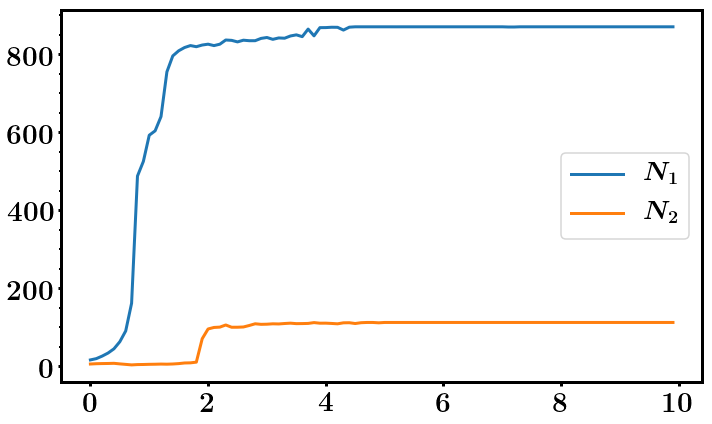

In [79]:
linestyles = ['-', '--']
ncols = 1
nrows = 1
fig, axes = plt.subplots(figsize=(10*ncols, 6*nrows), ncols=ncols, nrows=nrows)
axes = np.array([axes])
for ax, network in zip(axes.flatten(), networks):

    for i, rampe in enumerate(rampes[:1]):
        
        df = tr_dfs[network][rampe]
        mean_df = df.groupby(by='mu').mean()
        mu_values = mean_df.index
        N1_values = mean_df.N1
        N2_values = mean_df.N2
        
        if rampe == 'annealing':
            ax.plot(mu_values, N1_values, color=colors[0], label=r'$N_1$')
            ax.plot(mu_values, N2_values, color=colors[1], label=r'$N_2$')
        else:
            ax.plot(mu_values, N1_values, color=colors[0], linestyle='--', label='')
            ax.plot(mu_values, N2_values, color=colors[1], linestyle='--', label='')
    ax.legend(loc='best')  
plt.tight_layout()
plt.show()